In [37]:
import warnings, os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [38]:
import sys
sys.path.append("..")

## Import Base Packages

In [39]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as plt

from scipy.stats import skew, kurtosis

## Import Dal-IO Pieces

In [40]:
from dalio.base.memory import LazyRunner, LocalMemory

from dalio.external import (
    PandasInFile,
    YahooDR, 
    PyPlotGraph, 
    PyPfOptGraph,
    PySubplotGraph
)

from dalio.translator import (
    YahooStockTranslator,
    StockStreamFileTranslator,
)
    
from dalio.pipe import (
    Pipe,
    PipeLine,
    DateSelect,
    ColSelect, 
    Index,
    Change,
    StockReturns, 
    Period, 
    Custom, 
    Rolling,
    CovShrink, 
    ExpectedReturns,
    PandasLinearModel,
    OptimumWeights,
)

from dalio.model import (
    MakeCriticalLine, 
    MakeEfficientFrontier, 
    OptimumPortfolio,
    XYLinearModel,
)

from dalio.application import (
    Grapher,
    PandasTSGrapher,
    PandasMultiGrapher,
    LMGrapher,
)

from dalio.ops import risk_metrics

## Base Setup

In [41]:
yahoo_in = YahooStockTranslator()(YahooDR())
yahoo = ColSelect(columns="close")(yahoo_in)

In [42]:
stocks = StockStreamFileTranslator()(PandasInFile("../tests/sample_stocks.xlsx"))

In [43]:
raw_in = Pipe()(stocks)

In [44]:
time = DateSelect()
time.set_start("1999-12-31")
time.set_end("2019-12-31")

mem = LazyRunner(LocalMemory, buff=4, update=True)(raw_in) # 11.09 sec
# mem = raw_in # 28.14 sec
price = PipeLine(time)(mem)

In [45]:
simple_rets = price + Change(strategy="pct_change")

# ticker = ["WMT", "MSFT", "AMZN", "HD"]
# ticker = ["AMZN", "HD", "NVDA", "RL"]
ticker = ["NVDA", "RL", "GPS", "WMT"]
# ticker = ["GPS", "MSFT", "AMZN", "NVDA"]

In [46]:
price.run(ticker=ticker)

attribute        price                                   
ticker             WMT        NVDA          RL        GPS
date                                                     
1999-12-31   69.125000    3.911458   17.062500  46.000000
2000-01-03   66.812500    3.901042   17.437500  43.125000
2000-01-04   64.312500    3.796875   16.750000  41.562500
2000-01-05   63.000000    3.671875   17.062500  39.750000
2000-01-06   63.687500    3.432292   17.062500  44.437500
...                ...         ...         ...        ...
2019-12-24  119.510002  238.619995  118.339996  17.639999
2019-12-26  119.519997  239.190002  118.400002  17.930000
2019-12-27  119.589996  236.869995  117.410004  17.830000
2019-12-30  119.400002  232.320007  116.580002  17.820000
2019-12-31  118.839996  235.300003  117.220001  17.680000

[5032 rows x 4 columns]

## Part A

### Setup

In [47]:
daily_var = simple_rets + Custom(risk_metrics, 0.94)
daily_vol = daily_var + Custom(lambda x: np.sqrt(x))

In [48]:
daily_vol.run(ticker=ticker)

attribute      price                              
ticker           WMT      NVDA        RL       GPS
date                                              
1999-12-31  0.000000  0.000000  0.000000  0.000000
2000-01-03  0.033454  0.002663  0.021978  0.062500
2000-01-04  0.033454  0.002663  0.021978  0.062500
2000-01-05  0.033705  0.007032  0.023395  0.061242
2000-01-06  0.033058  0.010560  0.023138  0.060330
...              ...       ...       ...       ...
2019-12-24  0.006404  0.017605  0.021804  0.023380
2019-12-26  0.006287  0.017070  0.021171  0.022670
2019-12-27  0.006096  0.016560  0.020526  0.022345
2019-12-30  0.005912  0.016231  0.020006  0.021707
2019-12-31  0.005745  0.016424  0.019474  0.021046

[5032 rows x 4 columns]

In [49]:
ret_avg = simple_rets + Custom(np.mean)
ret_sd = simple_rets + Custom(np.std)
ret_skew = simple_rets + Custom(skew)
ret_kurt = simple_rets + Custom(kurtosis)

In [50]:
ret_avg.run(ticker=ticker)

attribute  ticker
price      WMT       0.000218
           NVDA      0.001541
           RL        0.000658
           GPS       0.000132
dtype: float64

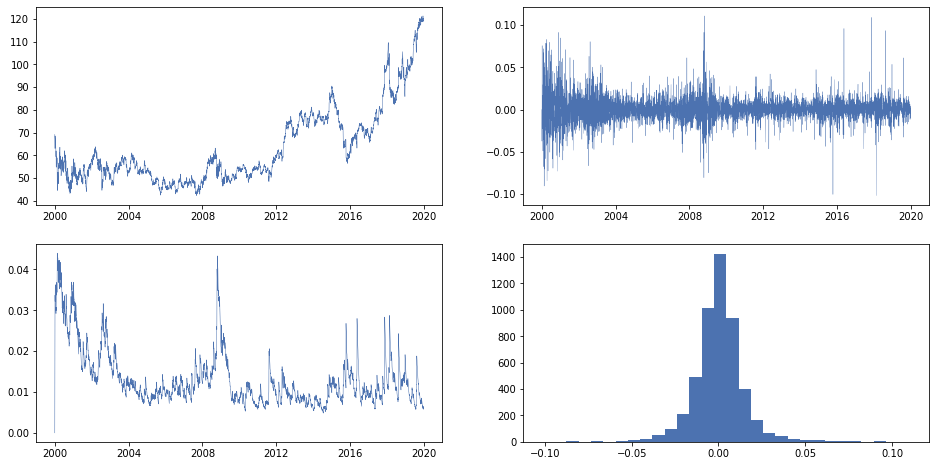

In [51]:
summary_grapher = PandasMultiGrapher(2, 2)\
    .set_input((0, 0), price)\
        .set_piece((0, 0), "line", x_index=True, y="price", lw=0.5)\
    .set_input((0, 1), simple_rets)\
        .set_piece((0, 1), "line", x_index=True, y="price", lw=0.3)\
    .set_input((1, 0), daily_vol)\
        .set_piece((1, 0), "line", x_index=True, y="price", lw=0.5)\
    .set_input((1, 1), simple_rets)\
        .set_piece((1, 1), "histogram", x="price", bins=30)\
    .set_output("data_out", PySubplotGraph(2, 2, figsize=(16, 8)))

fig = summary_grapher.run(ticker="WMT")

## Part B

### Setup

In [52]:
p = price.run(ticker=ticker)

In [53]:
p.resample("Y").apply(lambda x: x[-1])

attribute        price                                   
ticker             WMT        NVDA          RL        GPS
date                                                     
1999-12-31   69.125000    3.911458   17.062500  46.000000
2000-12-31   53.125000    5.460938   22.312500  25.500000
2001-12-31   57.549999   22.299999   26.760000  13.940000
2002-12-31   50.509998    3.836667   21.760000  15.520000
2003-12-31   53.049999    7.733333   28.799999  23.209999
2004-12-31   52.820000    7.853333   42.599998  21.120001
2005-12-31   46.799999   12.186666   56.139999  17.639999
2006-12-31   46.180000   24.673334   77.660004  19.500000
2007-12-31   47.529999   34.020000   61.790001  21.280001
2008-12-31   56.060001    8.070000   45.410000  13.390000
2009-12-31   53.450001   18.680000   80.980003  20.950001
2010-12-31   53.930000   15.400000  110.919998  22.139999
2011-12-31   59.759998   13.860000  138.080002  18.549999
2012-12-31   68.230003   12.260000  149.919998  31.040001
2013-12-31   78.690002   16.020000  176.570007  39.080002
2014-12-31   85.879997   20.049999  185.160004  42.110001
2015-12-31   61.299999   32.959999  111.480003  24.700001
2016-12-31   69.120003  106.739998   90.320000  22.440001
2017-12-31   98.750000  193.500000  103.690002  34.060001
2018-12-31   93.150002  133.500000  103.459999  25.760000
2019-12-31  118.839996  235.300003  117.220001  17.680000

In [54]:
annual_rets = price + Period("Y", agg_func=lambda x: (x[-1] - x[0])/x[0])

In [55]:
price

In [56]:
annual_rets = price + \
    Period("Y", agg_func=lambda x: x[-1]) + \
    Change(strategy="pct_change", rm_first=True)

In [57]:
annual_rets.run(ticker=ticker)

attribute      price                              
ticker           WMT      NVDA        RL       GPS
date                                              
1999-12-31  0.000000  0.000000  0.000000  0.000000
2000-12-31 -0.231465  0.396139  0.307692 -0.445652
2001-12-31  0.083294  3.083547  0.199328 -0.453333
2002-12-31 -0.122328 -0.827952 -0.186846  0.113343
2003-12-31  0.050287  1.015638  0.323529  0.495490
2004-12-31 -0.004336  0.015517  0.479167 -0.090047
2005-12-31 -0.113972  0.551783  0.317840 -0.164773
2006-12-31 -0.013248  1.024617  0.383327  0.105442
2007-12-31  0.029233  0.378816 -0.204352  0.091282
2008-12-31  0.179466 -0.762787 -0.265091 -0.370771
2009-12-31 -0.046557  1.314746  0.783308  0.564601
2010-12-31  0.008980 -0.175589  0.369721  0.056802
2011-12-31  0.108103 -0.100000  0.244861 -0.162150
2012-12-31  0.141734 -0.115440  0.085747  0.673316
2013-12-31  0.153305  0.306688  0.177762  0.259021
2014-12-31  0.091371  0.251560  0.048649  0.077533
2015-12-31 -0.286213  0.643890 -0.397926 -0.413441
2016-12-31  0.127569  2.238471 -0.189810 -0.091498
2017-12-31  0.428675  0.812816  0.148029  0.517825
2018-12-31 -0.056709 -0.310078 -0.002218 -0.243688
2019-12-31  0.275792  0.762547  0.132998 -0.313665

In [58]:
avg_rets = simple_rets + Period("Y", agg_func=np.mean)
var_rets = simple_rets + Period("Y", agg_func=np.var)
std_rets = simple_rets + Period("Y", agg_func=np.std)

In [59]:
ann_agg = annual_rets + Custom(np.mean)

In [60]:
ann_agg.run(ticker=ticker)

attribute  ticker
price      WMT       0.038237
           NVDA      0.500235
           RL        0.131225
           GPS       0.009792
dtype: float64

In [61]:
cov_rets = annual_rets + Custom(lambda x: x.cov(), strategy="pipe")
corr_rets = annual_rets + Custom(lambda x: x.corr(), strategy="pipe")

In [62]:
cov_rets.run(ticker=ticker)

attribute            price                              
ticker                 WMT      NVDA        RL       GPS
attribute ticker                                        
price     WMT     0.026033  0.018556  0.000466  0.018868
          NVDA    0.018556  0.845544  0.054015 -0.018938
          RL      0.000466  0.054015  0.079374  0.032883
          GPS     0.018868 -0.018938  0.032883  0.116630

In [63]:
S = CovShrink(frequency=252)(price)\
    .set_piece("shrinkage", "ledoit_wolf")

mu = ExpectedReturns()(price)\
    .set_piece("return_model", "james_stein_shrinkage")

In [64]:
cla_lo = MakeCriticalLine(weight_bounds=(0.05, 1))\
    .set_input("sample_covariance", cov_rets)\
    .set_input("expected_returns", ann_agg)

In [65]:
res = cla_lo.run(ticker=ticker)

In [66]:
res.efficient_frontier(points=100)

([0.43416232498121704,
  0.43416232498121704,
  0.43416232498121704,
  0.43416232498121704,
  0.43416232498121704,
  0.434162324981217,
  0.43416232498121693,
  0.43416232498121693,
  0.43416232498121693,
  0.43416232498121693,
  0.4341623249812169,
  0.4341623249812169,
  0.4341623249812169,
  0.4341623249812168,
  0.4341623249812168,
  0.4341623249812168,
  0.4208122416106094,
  0.407462158240002,
  0.3941120748693946,
  0.38076199149878714,
  0.3674119081281797,
  0.35406182475757225,
  0.34071174138696486,
  0.32736165801635736,
  0.31401157464575,
  0.3006614912751426,
  0.28731140790453513,
  0.2739613245339277,
  0.26061124116332024,
  0.24726115779271282,
  0.2339110744221054,
  0.2241351809741532,
  0.21435928752620093,
  0.20458339407824871,
  0.19480750063029645,
  0.18503160718234418,
  0.17525571373439194,
  0.1654798202864397,
  0.15570392683848747,
  0.14592803339053523,
  0.136152139942583,
  0.12637624649463075,
  0.1166003530466785,
  0.10682445959872625,
  0.09704856

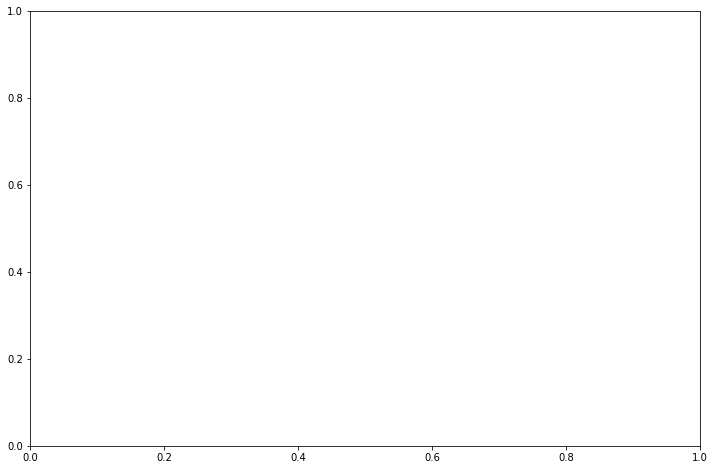

In [67]:
cla_graph = Grapher()\
    .set_input("data_in", cla_lo)\
    .set_output("data_out", PyPfOptGraph(figsize=(12, 8)))

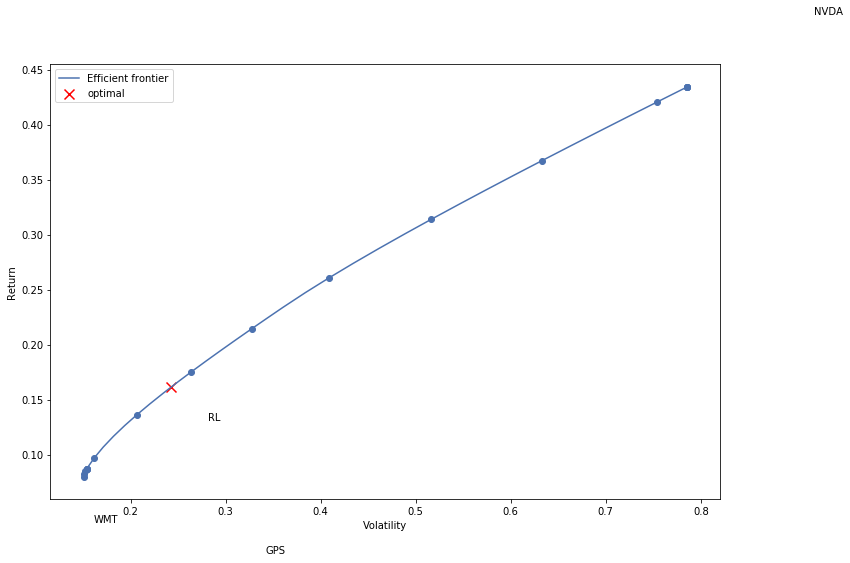

In [68]:
cla_graph.run(ticker=ticker)

## Part C

### Setup Efficient Frontier

In [69]:
ef_lo = MakeEfficientFrontier(weight_bounds=(0.05, 1))\
    .set_input("sample_covariance", cov_rets)\
    .set_input("expected_returns", ann_agg)

ef_ls = MakeEfficientFrontier(weight_bounds=(-1, 1))\
    .set_input("sample_covariance", cov_rets)\
    .set_input("expected_returns", ann_agg)

#### Get long-only efficient frontier

In [70]:
lo_res = ef_lo.run(ticker=ticker)

In [71]:
lo_res.max_sharpe(risk_free_rate=0.0)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'WMT': 0.3240757020532462,
 'NVDA': 0.1804326714685152,
 'RL': 0.4454916264782386,
 'GPS': 0.05}

In [72]:
lo_res.portfolio_performance()

(0.16159950594339884, 0.24295862066096674, 0.5828132607856378)

#### Get long-short efficient frontier

In [73]:
ls_res = ef_ls.run(ticker=ticker)

In [74]:
ls_res.max_sharpe(risk_free_rate=0.0)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'WMT': 0.5039882108698959,
 'NVDA': 0.1499854239780582,
 'RL': 0.522316725407506,
 'GPS': -0.17629036025546}

In [75]:
ls_res.portfolio_performance()

(0.16111353881182572, 0.2324207553132237, 0.6071468902235213)

#### Get optimum weights

In [76]:
max_shp_weights_lo = OptimumWeights()(ef_lo)\
    .set_piece("strategy", "max_sharpe", risk_free_rate=0.0)

max_shp_weights_ls = OptimumWeights()(ef_ls)\
    .set_piece("strategy", "max_sharpe", risk_free_rate=0.0)

min_vol_weights_lo = max_shp_weights_lo.with_piece("strategy", "min_volatility")

min_vol_weights_ls = max_shp_weights_ls.with_piece("strategy", "min_volatility")

In [77]:
max_shp_weights_lo.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'WMT': 0.32408, 'NVDA': 0.18043, 'RL': 0.44549, 'GPS': 0.05}

In [78]:
max_shp_weights_ls.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'WMT': 0.50399, 'NVDA': 0.14999, 'RL': 0.52232, 'GPS': -0.17629}

In [79]:
min_vol_weights_lo.run(ticker=ticker)

{'WMT': 0.70343, 'NVDA': 0.05, 'RL': 0.19657, 'GPS': 0.05}

In [80]:
min_vol_weights_ls.run(ticker=ticker)

{'WMT': 0.78186, 'NVDA': -0.01168, 'RL': 0.26479, 'GPS': -0.03497}

## Part D

### Setup

In [81]:
two_years = DateSelect()\
    .set_start("2018-01-01")\
    .set_end("2019-12-31")

price_2y = PipeLine(two_years)(mem)
rets_2y = simple_rets.with_input(price_2y)

In [82]:
lm = PandasLinearModel()\
    .set_input(Index(100)(price_2y))\
    .set_piece("strategy", "LinearRegression")

In [83]:
res = lm.run(ticker=ticker)

In [84]:
res.intercept_

array([ 85.73506574, 122.64274603, 117.85329192, 102.61918028])

In [85]:
res.coef_

array([[ 0.06416141],
       [-0.08205923],
       [-0.03095355],
       [-0.11105704]])

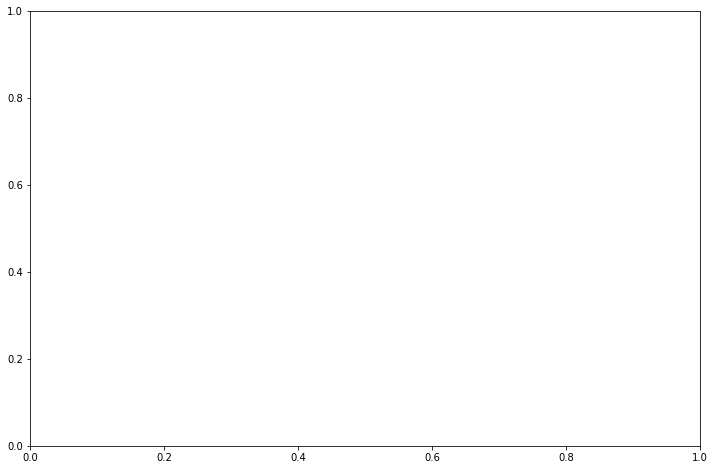

In [86]:
all_lm_graph = LMGrapher(legend="upper left")\
    .set_input("data_in", Index(100)(price_2y))\
    .set_input("linear_model", lm)\
    .set_output("data_out", PyPlotGraph(figsize=(12, 8)))

../dalio/application/graphers.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


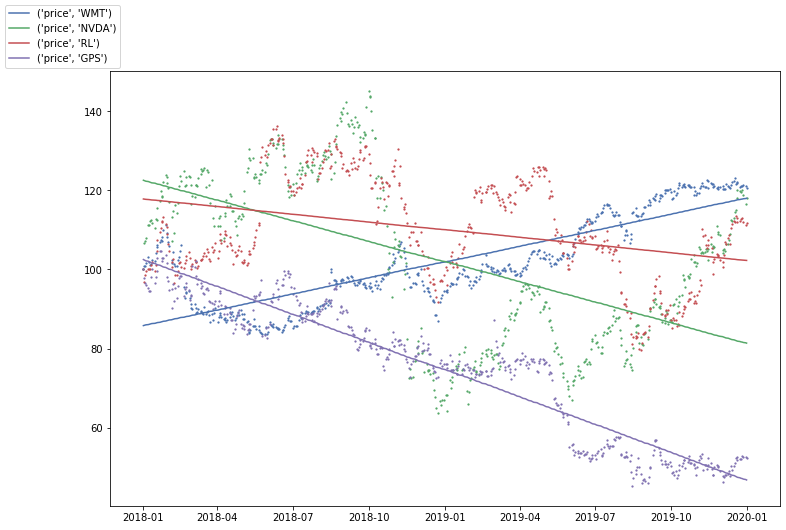

In [87]:
all_lm_graph.run(ticker=ticker)

In [88]:
comp_tick = "WMT"

spy = ColSelect(("price", "SPY"))(rets_2y)
comp = ColSelect(("price", comp_tick))(rets_2y)

 # Using simple_rets for full data optimization
opt_port = OptimumPortfolio()\
    .set_input("data_in", simple_rets)\
    .set_input("weights_in", max_shp_weights_lo)

sp500_lm = XYLinearModel()\
    .set_input("x", spy)\
    .set_input("y", two_years(opt_port))\
    .set_piece("strategy", "LinearRegression")

lm_res = sp500_lm.run(ticker=[comp_tick, "SPY"])

/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR

In [89]:
opt_port.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_ite

attribute,price
ticker,portfolio
date,
1999-12-31,0.000000
2000-01-03,-0.004656
2000-01-04,-0.036320
2000-01-05,-0.006423
2000-01-06,-0.002340
...,...
2019-12-24,0.003179
2019-12-26,0.001506


In [90]:
lm_res.coef_

array([[0.8576271]])

In [91]:
lm_res.score(
    spy.run(), 
    comp.run()
)

/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


0.19497781412284798

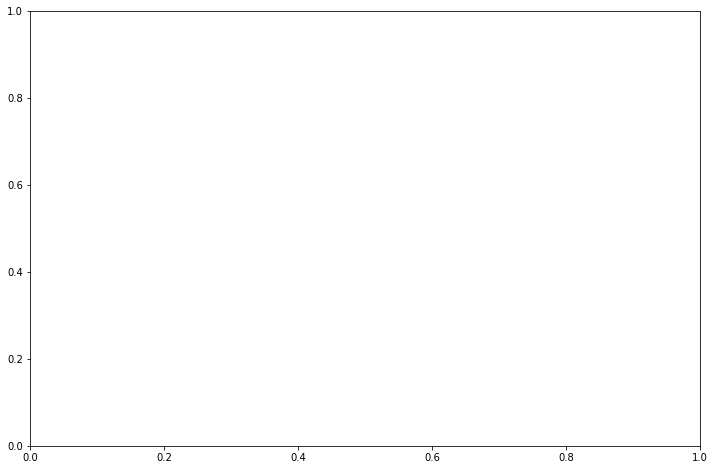

In [92]:
sp500_lm_graph = LMGrapher(x=("price", "SPY"), y=("price", "WMT"))\
    .set_input("data_in", rets_2y)\
    .set_input("linear_model", sp500_lm)\
    .set_output("data_out", PyPlotGraph(figsize=(12, 8)))

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
../dalio/application/graphers.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


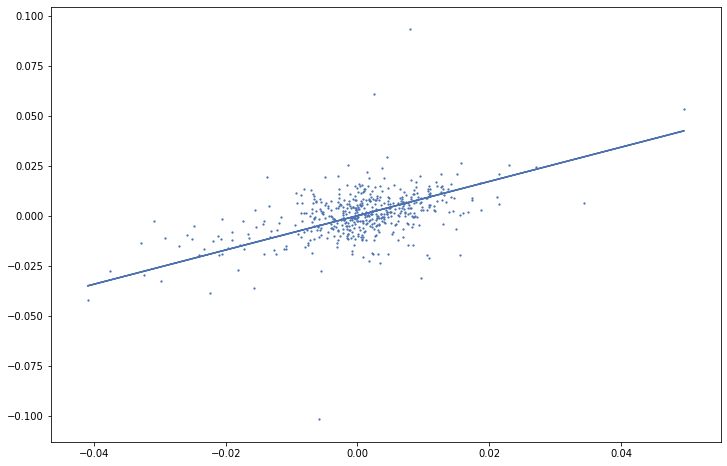

In [93]:
sp500_lm_graph.run(ticker=["WMT", "SPY"])

## Part E

### Setup

In [94]:
sp500_const = MakeEfficientFrontier(weight_bounds=(0.05, 1))\
    .set_input("sample_covariance", cov_rets)\
    .set_input("expected_returns", ann_agg)\
    .add_stock_weight_constraint(ticker="SPY", comparisson="==", weight=0.6)

In [95]:
res = sp500_const.run(ticker=ticker+["SPY"])

/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [96]:
res.max_sharpe(risk_free_rate=0.0)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'SPY': 0.6,
 'WMT': 0.05,
 'NVDA': 0.186097268701167,
 'RL': 0.113902731298833,
 'GPS': 0.05}

In [97]:
res.portfolio_performance()

(0.14243799883634214, 0.2453808701895622, 0.4989712471952522)

In [98]:
sp_opt_weights = max_shp_weights_lo.with_input(sp500_const)

In [99]:
sp_opt_port = opt_port\
    .with_input("weights_in", sp_opt_weights)\
    .set_input("data_in", annual_rets)

In [100]:
sp_opt_port.run(ticker=ticker+["SPY"])

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_ite

attribute,price
ticker,portfolio
date,
1999-12-31,0.000000
2000-12-31,0.014077
2001-12-31,0.499793
2002-12-31,-0.316009
2003-12-31,0.411432
2004-12-31,0.106706
2005-12-31,0.142958
2006-12-31,0.320669


In [101]:
simple_rets.run(ticker="SPY")

/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/renatomz/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


attribute,price
ticker,SPY
date,
1999-12-31,0.000000
2000-01-03,-0.009549
2000-01-04,-0.038345
2000-01-05,0.001922
2000-01-06,0.000956
...,...
2019-12-24,-0.000195
2019-12-26,0.005128
